# Data Centers & Environmental Justice in Oregon

## Introduction

The rapid expansion of artificial intelligence (AI) and cloud computing has driven unprecedented growth in data center infrastructure across the United States. Data centers—facilities housing computing equipment for data storage, processing, and distribution—have become critical infrastructure for the digital economy, yet their environmental footprint raises significant concerns for local communities (Mytton, 2021; Shehabi et al., 2016).

### The Environmental Footprint of Data Centers

Data centers are among the most energy-intensive building types, consuming approximately 1-2% of global electricity (IEA, 2024). In the United States, data center electricity consumption is projected to triple by 2030, reaching up to 12% of national power demand (EPRI, 2024). This growth has significant environmental implications:

- **Energy consumption**: A single large data center can consume as much electricity as 50,000 homes (Masanet et al., 2020)
- **Water usage**: Data centers require substantial water for cooling systems, with some facilities using millions of gallons daily (Siddik et al., 2021)
- **Air quality**: Backup diesel generators and increased grid demand contribute to local air pollution (Lei & Masanet, 2020)
- **Land use**: Large-scale facilities transform landscapes and can displace other land uses

### Environmental Justice Implications

Environmental justice research has documented that polluting facilities and environmental hazards are disproportionately sited in communities with higher proportions of low-income residents and people of color (Bullard, 1990; Mohai et al., 2009). While data centers are often characterized as "clean" industry compared to traditional manufacturing, their large environmental footprint warrants investigation into potential environmental justice implications.

### Oregon as a Case Study

Oregon has become a hub for data center development due to favorable climate (reducing cooling costs), abundant hydroelectric power, and tax incentives. Major technology companies including Google, Facebook, and Amazon have established significant data center operations in the state. However, the distribution of these facilities across Oregon's counties and their relationship to environmental justice indicators has not been systematically examined.

### Research Questions

This analysis addresses the following questions:

1. How are existing data centers in Oregon distributed relative to environmental justice indicators?
3. What patterns emerge for projected future data center locations, and do these amplify or mitigate existing disparities?

### Data and Methods

We integrate three primary data sources to conduct this spatial analysis:

**EJScreen State Percentile Indicators (22 total):**
- *Demographic*: People of Color, Low Income, Unemployment, Disability, Linguistic Isolation, Less Than High School, Under 5, Over 64, Life Expectancy
- *Environmental*: PM2.5, Ozone, Diesel PM, Toxic Releases (RSEI), Traffic Proximity, Lead Paint, Superfund (NPL), RMP Facilities, TSDF, Underground Storage Tanks, Wastewater Discharge, NO2, Drinking Water

EJScreen data is originally at the census tract level; we aggregate tract-level indicators to the county level by taking the mean percentile across all tracts within each county.

**Data sources:**
- Existing data centers: [IM3 Open Source Data Center Atlas](https://github.com/shawn15goh/Data-Center-Location-USA-Datasets) from Pacific Northwest National Laboratory
- Projected data centers: [IM3 higher_growth scenario (0% market gravity)](https://github.com/shawn15goh/Data-Center-Location-USA-Datasets) from Pacific Northwest National Laboratory
- EJScreen: `EJScreen_2024_Tract_StatePct_with_AS_CNMI_GU_VI.csv` from [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/RLR5AX)
- County boundaries: US Census TIGER/Line 2020 shapefiles

### References

- Bullard, R. D. (1990). *Dumping in Dixie: Race, class, and environmental quality*. Westview Press.
- EPRI. (2024). *Powering intelligence: Analyzing artificial intelligence and data center energy consumption*. Electric Power Research Institute.
- IEA. (2024). *Electricity 2024: Analysis and forecast to 2026*. International Energy Agency.
- Lei, N., & Masanet, E. (2020). Statistical analysis for predicting location-specific data center PUE and its improvement potential. *Energy*, 201, 117556.
- Masanet, E., Shehabi, A., Lei, N., Smith, S., & Koomey, J. (2020). Recalibrating global data center energy-use estimates. *Science*, 367(6481), 984-986.
- Mohai, P., Pellow, D., & Roberts, J. T. (2009). Environmental justice. *Annual Review of Environment and Resources*, 34, 405-430.
- Mytton, D. (2021). Data centre water consumption. *npj Clean Water*, 4(1), 11.
- Shehabi, A., Smith, S., Sartor, D., Brown, R., Herrlin, M., Koomey, J., ... & Lintner, W. (2016). *United States data center energy usage report* (No. LBNL-1005775). Lawrence Berkeley National Laboratory.
- Siddik, M. A. B., Shehabi, A., & Marston, L. (2021). The environmental footprint of data centers in the United States. *Environmental Research Letters*, 16(6), 064017.

## 1. Imports

In [27]:
import geopandas as gpd
import ibis
from ibis import _
import ibis.selectors as s
import seaborn.objects as so
import leafmap.maplibregl as leafmap

## 2. Load Existing Data Centers
We chose to use the IM3 Open Source Data Center Atlas, made by the Pacific Northwest National Laboratory (PNNL). It contains the locations of existiing data center facilities in the US, deriving data from OpenStreetMap (OSM), a crowd-sourced database. We chose this dataset as it was published recently (June 6th, 2025), is credible (from PNNL scientists), and has variables such as county and state, which are important for our analysis. 

To access the data, we chose to upload it to a public GitHub repo rather than loading it into the notebook from the webpage, as we were unable to find a direct url to read in the data. 

We accessed and downloaded the data from https://data.msdlive.org/records/65g71-a4731 on November 9th. 2025, and uploaded to GitHub at (https://github.com/shawn15goh/Data-Center-Location-USA-Datasets) the same day. No changes to the data has been made since June 6th, 2025, and thus the data in the Github repo is up to date. 

Load in IM3 existing data centers data

In [28]:
con = ibis.duckdb.connect()

existing_url = "https://raw.githubusercontent.com/shawn15goh/Data-Center-Location-USA-Datasets/main/im3_open_source_data_center_atlas/im3_open_source_data_center_atlas.csv"
existing = con.read_csv(existing_url)

Filter the dataset to include Oregon only

In [29]:
existing_or = existing.filter(_.state == "Oregon").execute()

Convert the dataset to a Geodataframe in order to define geometry. Use the 'latitude' and 'longitude' columns under coordinate reference system (CRS) EPSG 4326 for the geometry.

In [30]:
existing_or = gpd.GeoDataFrame(
    existing_or,
    geometry=gpd.points_from_xy(existing_or["lon"], existing_or["lat"]),
    crs="EPSG:4326",
)

## 3. Load Projected Data Centers
We chose to use the IM3 Projected US Data Center Locations datasets, made by the Pacific Northwest National Laboratory (PNNL). It contains the model projects for locations of future data center facilities in the contiguous United States (CONUS) through 2035 using the CERF – Data Centers model. We chose this dataset as it was published recently (August 14th, 2025), is credible (from PNNL scientists), and has variables such as county and state, which are important for our analysis. 

To access the data, we chose to upload it to a public GitHub repo rather than loading it into the notebook from the webpage, as we were unable to find a direct url to read in the data. 

We accessed and downloaded the data from https://data.msdlive.org/records/8fd09-xhn32 on November 9th. 2025, and uploaded to GitHub at (https://github.com/shawn15goh/Data-Center-Location-USA-Datasets) the same day. No changes to the data has been made since August 14th, 2025, and thus the data in the Github repo is up to date.

Data center locations are modeled across four data center electricity demand growth scenarios (low, moderate, high, higher) and five market gravity scenarios (0%, 25%, 50%, 75%, 100%).

Market gravity scenarios correspond to the relative importance of proximity to data center markets or high population areas compared to locational cost, with 0% meaning that siting decisions are entirely determined by locational cost.

We choose to use the higher growth scenario to map all possible projected data center locations, including those predicted under lower growth scenarios.

We choose to use 0% market gravity to explore possibilities of new locations and data center markets, rather than having all projected data centers be concentrated near existing data centers. 

The original data contains polygon geometries representing potential development zones, which we convert to centroid points for analysis, to remain consistent with the existing data center dataset. 

Load in IM3 projected data centers 

In [31]:
projected_url = "https://raw.githubusercontent.com/shawn15goh/Data-Center-Location-USA-Datasets/main/im3_projected_data_centers/higher_growth/higher_growth_0_market_gravity.geojson"
projected = con.read_geo(projected_url)

Filter dataset to include Oregon only

In [32]:
projected_or = projected.filter(_.region == "oregon").execute()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Set geometry using the 'geom' column, calculate polygon centroids in the original CRS (ESRI:102003) for spatial accuracy, then reproject to EPSG:4326 for consistency with other datasets

In [33]:
projected_or = projected_or.set_geometry("geom").set_crs("ESRI:102003")
projected_or["geometry"] = projected_or.geometry.centroid
projected_or = projected_or.drop(columns="geom").set_geometry("geometry").to_crs("EPSG:4326")

## 4. Load EJScreen Data and Aggregate to Counties

EJScreen is EPA's environmental justice mapping tool. We download census tract-level data and aggregate to county level by computing the mean state percentile for each indicator across all tracts within each county. 

We choose to use percentiles instead of raw data for a more standardized comparison between indicators. The percentiles from this data set are at a state level which is appropriate for our analysis that focuses solely on Oregon. 

We choose to conduct analysis from a county level instead of census-tract as policies that influence data center siting (e.g. tax breaks and economic development zones) are typically set at the county level. 

Create a list and dictionary of all the percentile indicators that EJScreen provides

In [34]:
indicator_cols = [
    "P_PEOPCOLORPCT", "P_LOWINCPCT", "P_UNEMPPCT", "P_DISABILITYPCT", "P_LINGISOPCT",
    "P_LESSHSPCT", "P_UNDER5PCT", "P_OVER64PCT", "P_LIFEEXPPCT", "P_PM25", "P_OZONE",
    "P_DSLPM", "P_RSEI_AIR", "P_PTRAF", "P_LDPNT", "P_PNPL", "P_PRMP", "P_PTSDF",
    "P_UST", "P_PWDIS", "P_NO2", "P_DWATER"
]

indicator_labels = {
    "P_PEOPCOLORPCT": "People of Color",
    "P_LOWINCPCT": "Low Income",
    "P_UNEMPPCT": "Unemployment",
    "P_DISABILITYPCT": "Disability",
    "P_LINGISOPCT": "Linguistic Isolation",
    "P_LESSHSPCT": "Less Than High School",
    "P_UNDER5PCT": "Under 5 Years",
    "P_OVER64PCT": "Over 64 Years",
    "P_LIFEEXPPCT": "Life Expectancy",
    "P_PM25": "PM2.5",
    "P_OZONE": "Ozone",
    "P_DSLPM": "Diesel PM",
    "P_RSEI_AIR": "Toxic Releases (RSEI)",
    "P_PTRAF": "Traffic Proximity",
    "P_LDPNT": "Lead Paint",
    "P_PNPL": "Superfund (NPL)",
    "P_PRMP": "RMP Facilities",
    "P_PTSDF": "Hazardous Waste (TSDF)",
    "P_UST": "Underground Storage Tanks",
    "P_PWDIS": "Wastewater Discharge",
    "P_NO2": "NO2",
    "P_DWATER": "Drinking Water"
}

Load in EJScreen data from Harvard Dataverse

In [35]:
ej_url = "https://dataverse.harvard.edu/api/access/datafile/10775973"
ejs = con.read_csv(ej_url)

Filter EJScreen data to only include Oregon

In [36]:
ejs_or = ejs.filter(_.ST_ABBREV == "OR")

Aggregate tract-level EJScreen indicators to county level (mean across tracts)

In [37]:
ejs_county_or = (
    ejs_or
    .group_by("CNTY_NAME")
    .aggregate([ejs_or[col].mean().name(col) for col in indicator_cols])
).execute()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Load Oregon county geometries from Census TIGER/Line

In [38]:
cgeom_url = "https://www2.census.gov/geo/tiger/TIGER2020/COUNTY/tl_2020_us_county.zip"
cgeom = gpd.read_file(cgeom_url).to_crs("EPSG:4326")

Filter county geometry data to only include Oregon, which has StateFP of 41, and keep only the county names and geometries

In [39]:
cgeom_or = cgeom[cgeom["STATEFP"] == "41"][["NAMELSAD", "geometry"]]

Merge aggregated EJScreen data onto county geometries so that it can be plotted later

In [40]:
counties = cgeom_or.merge(ejs_county_or, left_on="NAMELSAD", right_on="CNTY_NAME", how="left").drop(columns="NAMELSAD")

## 5. Spatial Join: Data Centers to Counties

We perform spatial joins for both existing and projected data centers to determine which county each data center falls within. Then we join it with the EJ Screen and county geometry data we found earlier. This allows us to analyze the demographic and environmental characteristics of counties that contain data centers.

In [41]:
ex_counties = gpd.sjoin(existing_or, counties[["CNTY_NAME", "geometry"]], predicate="within")["CNTY_NAME"].unique()
pr_counties = gpd.sjoin(projected_or, counties[["CNTY_NAME", "geometry"]], predicate="within")["CNTY_NAME"].unique()

county_dc_data = counties.copy()
county_dc_data["has_existing_dc"] = county_dc_data["CNTY_NAME"].isin(ex_counties)
county_dc_data["has_projected_dc"] = county_dc_data["CNTY_NAME"].isin(pr_counties)

Save to a parquet file for analysis with ibis

In [42]:
county_dc_data.drop(columns="geometry").to_parquet("docs/county_dc_data.parquet")

## 6. Analysis: EJ Indicators in Data Center Counties

We compare environmental justice indicators between counties that contain data centers and those that don't. County-level indicators are the mean of tract-level state percentiles within each county. We calculate the difference in mean percentile for counties with and without data centers (for both existing and projected) to identify the most significant indicators for mapping.

Read in the parquet file for ibis analysis

In [43]:
county_ibis = con.read_parquet("docs/county_dc_data.parquet")

Aggregate the indicator means for couunties with/without existing data centers

In [44]:
has_dc_means = (
    county_ibis
    .filter(_.has_existing_dc == True)
    .aggregate([county_ibis[col].mean().name(col) for col in indicator_cols])
    .pivot_longer(s.all(), names_to="Indicator", values_to="has_dc_mean", names_transform=indicator_labels.get)
)

no_dc_means = (
    county_ibis
    .filter(_.has_existing_dc == False)
    .aggregate([county_ibis[col].mean().name(col) for col in indicator_cols])
    .pivot_longer(s.all(), names_to="Indicator", values_to="no_dc_mean", names_transform=indicator_labels.get)
)

Create a table that compares and colors codes the difference in means of the various indicators for counties with vs without existing data centers

In [45]:
existing_summary = (
    has_dc_means
    .join(no_dc_means, "Indicator")
    .mutate(Difference=_.has_dc_mean - _.no_dc_mean)
    .mutate(Color=ibis.ifelse(_.Difference > 0, "Higher in DC", "Lower in DC"))
    .order_by("Difference")
    .execute()
)

Repeat the 2 above steps for counties with/without projected data centers

In [46]:
has_pr_means = (
    county_ibis
    .filter(_.has_projected_dc == True)
    .aggregate([county_ibis[col].mean().name(col) for col in indicator_cols])
    .pivot_longer(s.all(), names_to="Indicator", values_to="has_dc_mean", names_transform=indicator_labels.get)
)

no_pr_means = (
    county_ibis
    .filter(_.has_projected_dc == False)
    .aggregate([county_ibis[col].mean().name(col) for col in indicator_cols])
    .pivot_longer(s.all(), names_to="Indicator", values_to="no_dc_mean", names_transform=indicator_labels.get)
)

projected_summary = (
    has_pr_means
    .join(no_pr_means, "Indicator")
    .mutate(Difference=_.has_dc_mean - _.no_dc_mean)
    .mutate(Color=ibis.ifelse(_.Difference > 0, "Higher in DC", "Lower in DC"))
    .order_by("Difference")
    .execute()
)

Plot a bar chart of EJ indicator differences between counties with and without data centers (for both existing and projected data centers)

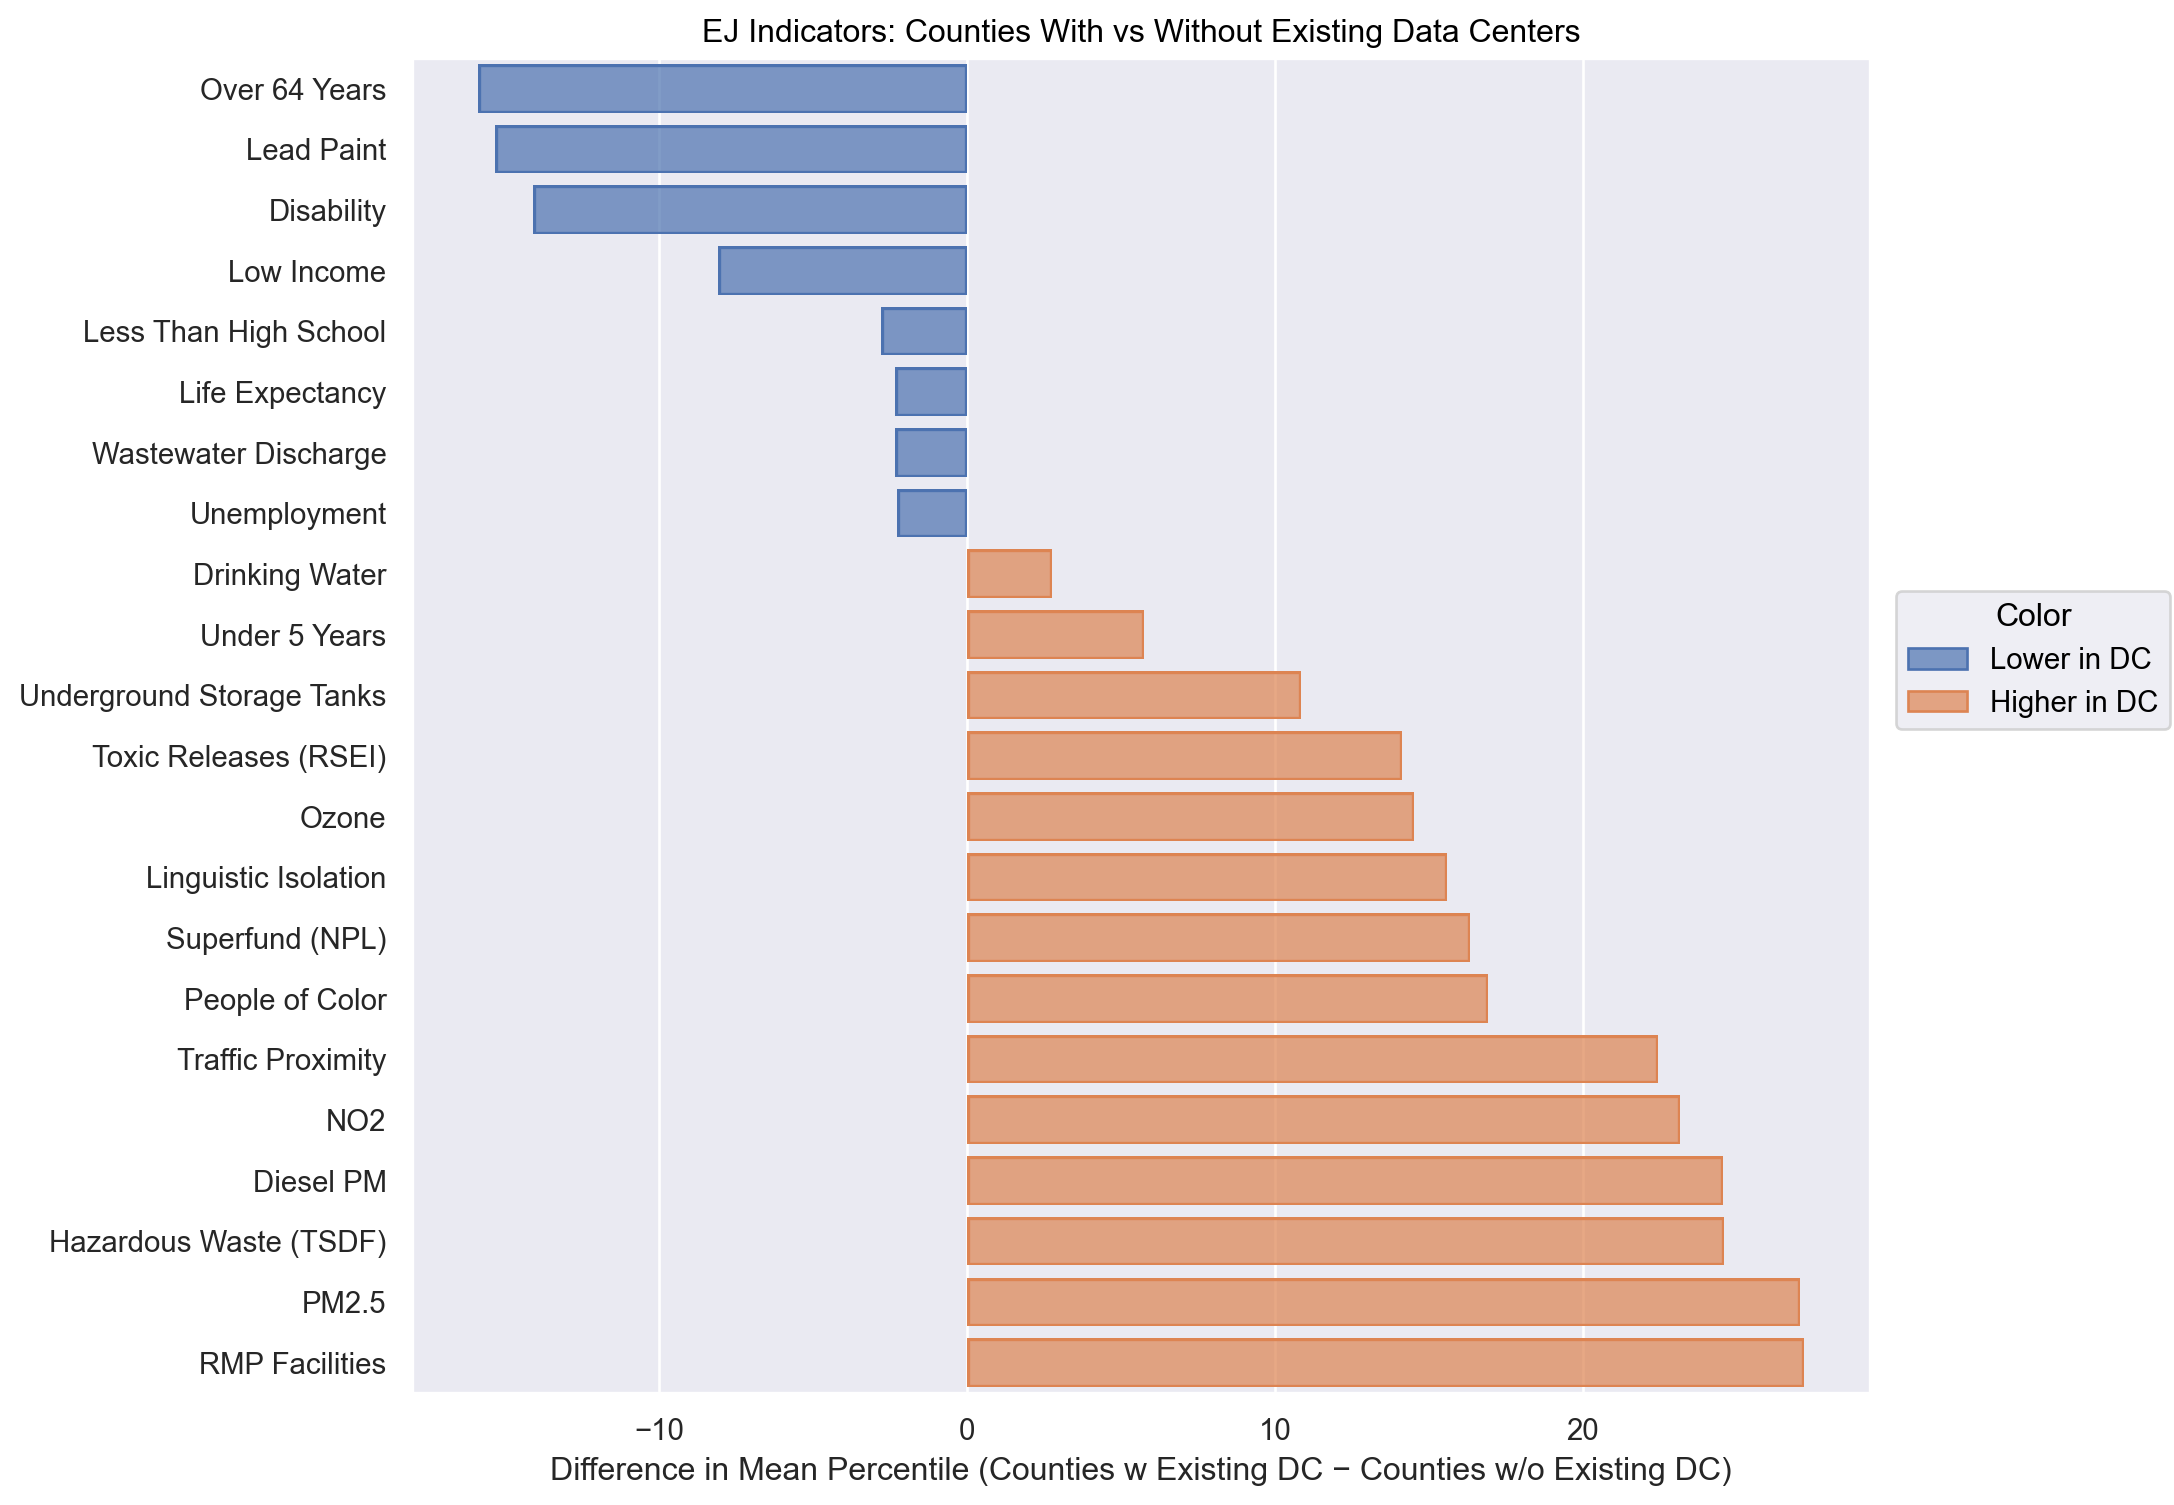

In [47]:
(
    so.Plot(existing_summary, y="Indicator", x="Difference", color="Color")
    .add(so.Bar())
    .label(x="Difference in Mean Percentile (Counties w Existing DC − Counties w/o Existing DC)", y="", title="EJ Indicators: Counties With vs Without Existing Data Centers")
    .layout(size=(10, 8))
)

**Analysis: Existing Data Centers**

Counties with existing data centers show notably **higher environmental burdens** compared to counties without:

- **Air quality indicators** are substantially elevated: PM2.5 (+27 percentile points), Diesel PM (+24), and NO2 (+22) show the largest positive differences, indicating poorer air quality in data center counties
- **Industrial hazard proximity** is higher: RMP Facilities (+27), Hazardous Waste (TSDF) (+25), and Superfund sites (+15) suggest data centers are co-located with industrial infrastructure
- **Demographic indicators** show a mixed pattern: People of Color (+15) and Linguistic Isolation (+14) are higher in DC counties, while Low Income (-8), Disability (-11), and Over 64 Years (-14) are lower

This pattern suggests existing data centers in Oregon are located in **more urbanized, industrialized counties** with younger, more diverse populations but also with greater exposure to air pollution and industrial facilities.

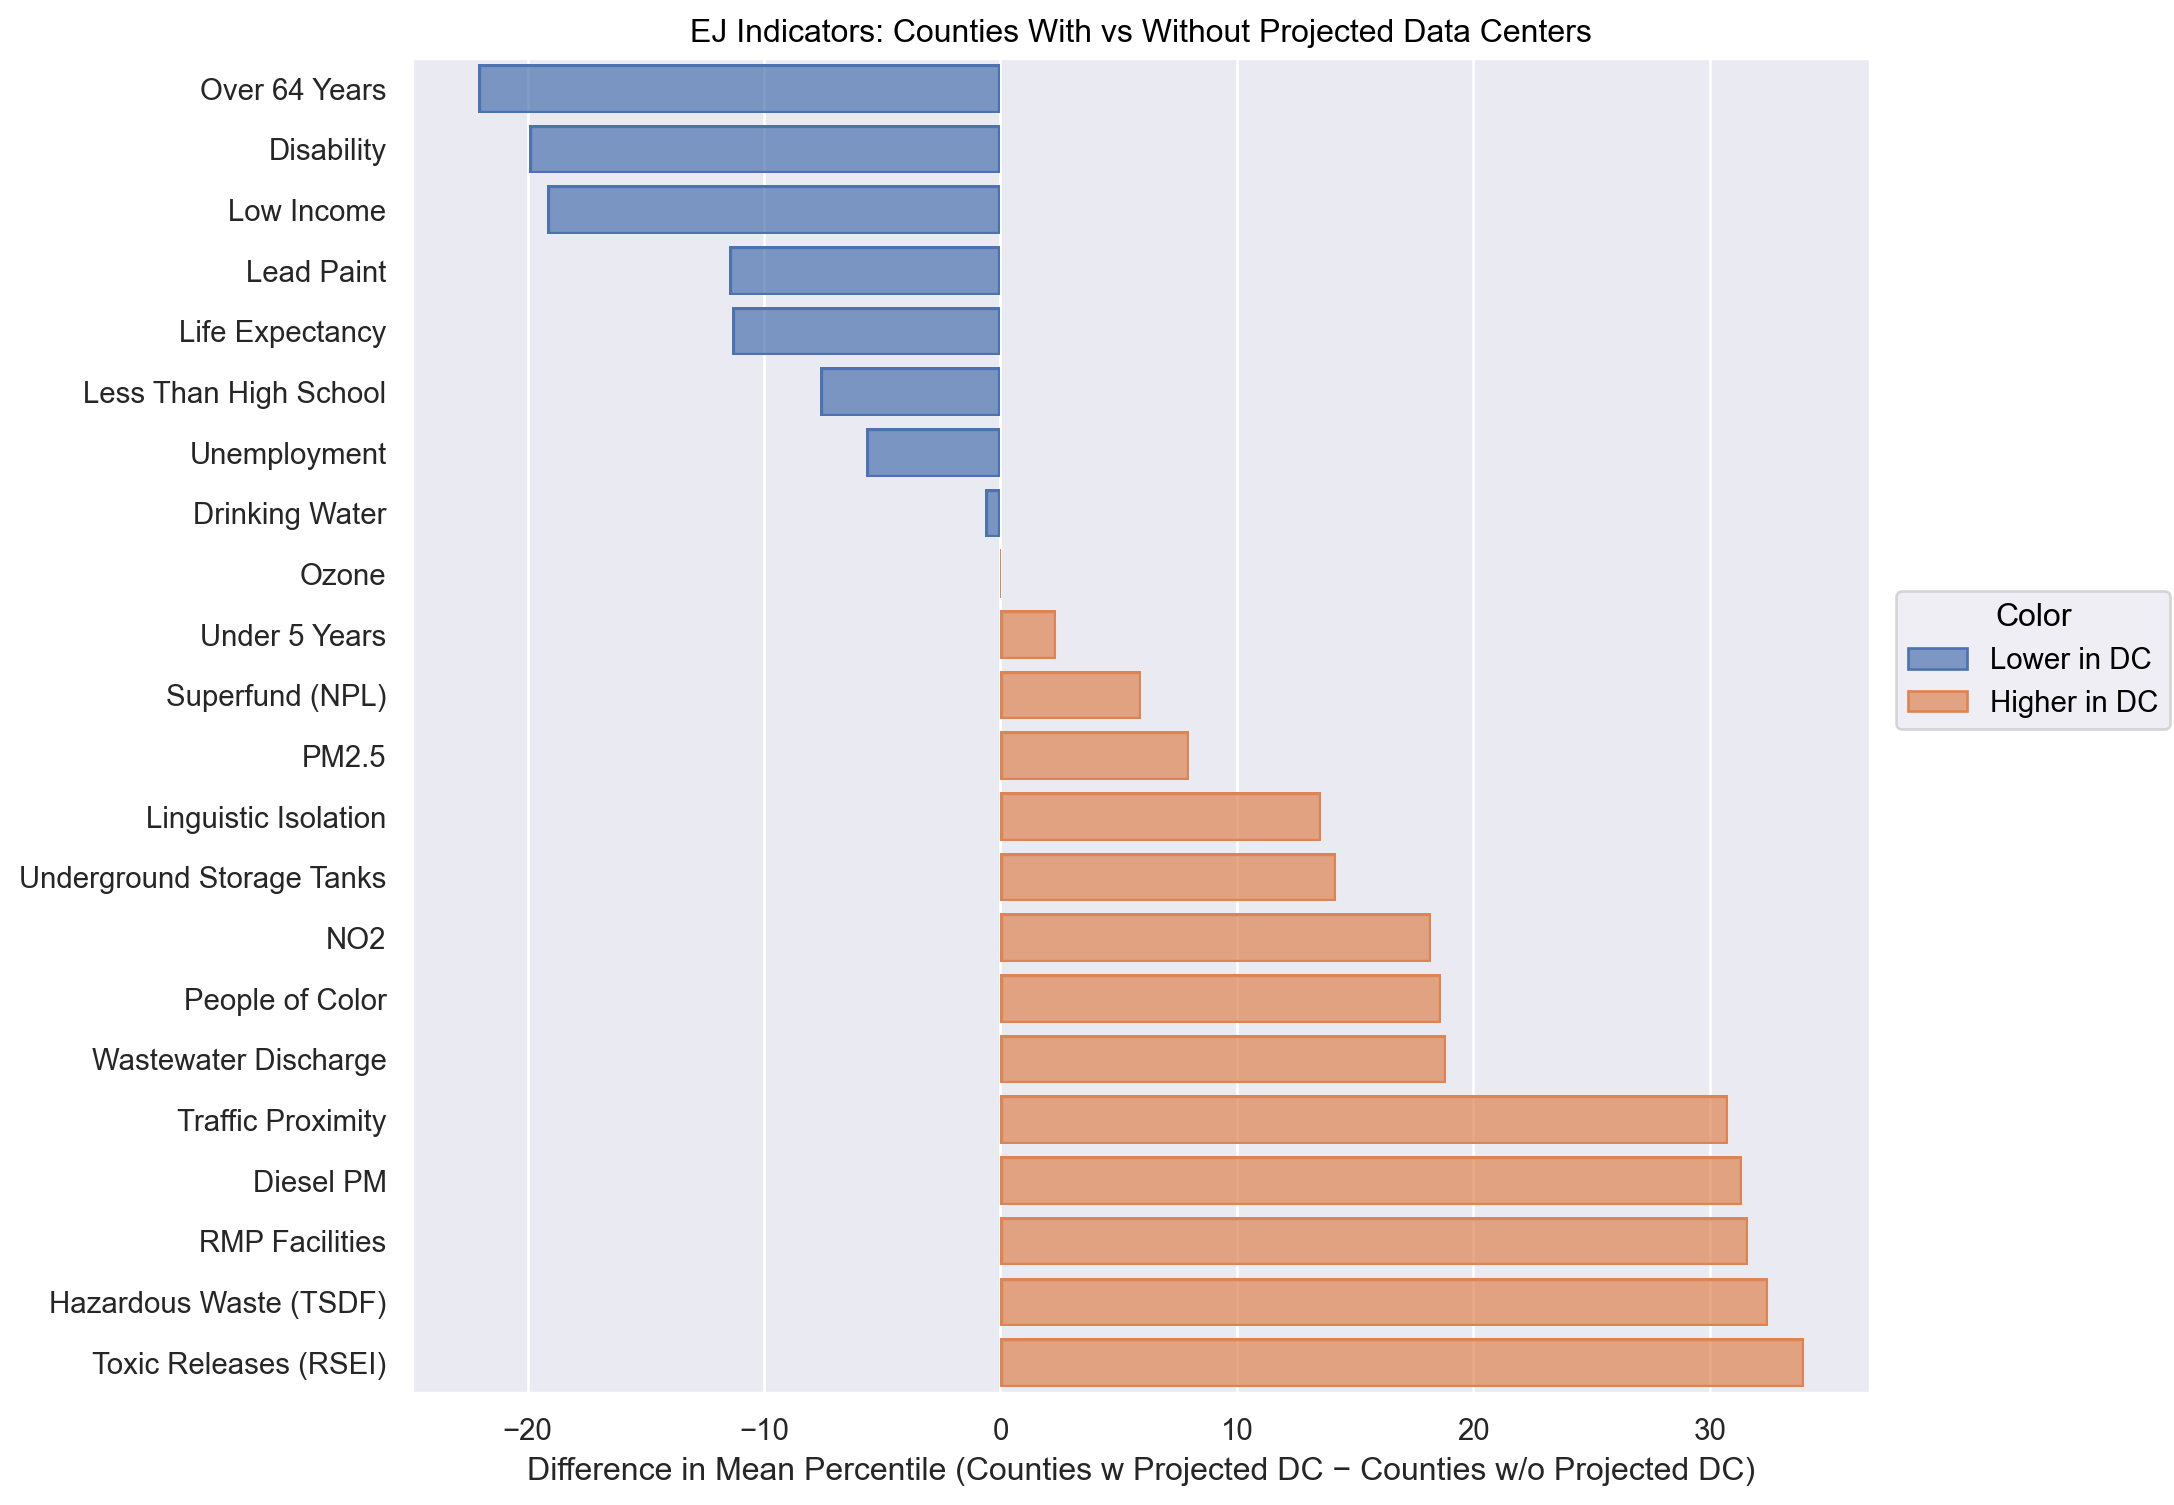

In [48]:
(
    so.Plot(projected_summary, y="Indicator", x="Difference", color="Color")
    .add(so.Bar())
    .label(x="Difference in Mean Percentile (Counties w Projected DC − Counties w/o Projected DC)", y="", title="EJ Indicators: Counties With vs Without Projected Data Centers")
    .layout(size=(10, 8))
)

**Analysis: Projected Data Centers**

Counties slated for projected data center development show an even **more pronounced pattern** of environmental justice concerns:

- **Industrial and toxic exposure** indicators are highest: Toxic Releases (RSEI) (+33), Hazardous Waste (TSDF) (+30), RMP Facilities (+29), and Diesel PM (+29) show the largest differences
- **Traffic and infrastructure burden**: Traffic Proximity (+28) and Underground Storage Tanks (+13) indicate these are areas with existing transportation and industrial infrastructure
- **Demographic vulnerability**: People of Color (+16), Wastewater Discharge (+18), and Linguistic Isolation (+11) are elevated, suggesting projected expansion targets counties with vulnerable populations
- **Rural characteristics remain lower**: Over 64 Years (-25), Disability (-21), Low Income (-20), and Lead Paint (-14) are substantially lower, consistent with younger, less rural county profiles

**Key Insight**: Comparing both charts, projected data centers appear to **amplify existing patterns**—the environmental burden differences are generally larger for projected sites than existing ones. This suggests future data center development in Oregon may disproportionately impact communities already facing elevated environmental hazards and with higher proportions of people of color and linguistically isolated populations, raising important environmental justice considerations for siting decisions.

## 7. Interactive Map: Data Centers and EJ Indicators

To gain a better understanding of the spatial distribution of data centers as compared to different environmental justice indicators, we will plot them all onto an interactive map. 

For clarity, we aggregate the indicators of proximity to environmental hazards into one broad indicator, by taking the mean of their percentiles in each county. We do the same for indicators of air quality. 

For demographic indicators, we chose to solely focus on people of color, so as to decouple vulnerability from the economic impact of data center development, such as on income and employment which has been well documented in literature. 

Below is the breakdown of the map layers and which indicators are aggregated to one another. 

**Data Center Layers:**
- **Blue points**: Existing data centers
- **Red points**: Projected data centers (higher_growth and 0% market gravity scenario)

**EJ Indicator Layers (county-level mean state percentiles):**
- **People of Color** (purple): % People of Color state percentile
- **Hazard Proximity** (red): Average of Superfund, RMP Facilities, TSDF, Underground Storage Tanks, Wastewater Discharge, and Traffic Proximity percentiles
- **Air Quality Burden** (orange): Average of PM2.5, Ozone, Diesel PM, NO2, and Toxic Releases to Air (RSEI) percentiles

Higher percentiles indicate greater environmental burden or demographic vulnerability relative to other Oregon counties.

Calculate the new aggregated indicators for hazard proximity and air quality, and drop unncessary columns. 

In [49]:
hazard_cols = ["P_PNPL", "P_PRMP", "P_PTSDF", "P_UST", "P_PWDIS", "P_PTRAF"]
air_cols = ["P_PM25", "P_OZONE", "P_DSLPM", "P_NO2", "P_RSEI_AIR"]

county_dc_data["Hazard_Proximity"] = county_dc_data[hazard_cols].mean(axis=1)
county_dc_data["Air_Quality"] = county_dc_data[air_cols].mean(axis=1)

map_counties = county_dc_data[["CNTY_NAME", "geometry", "P_PEOPCOLORPCT", "Hazard_Proximity", "Air_Quality"]]

Plot an interactive map of the 3 environmental justice indicators: People of Color (purple), Hazard Proximity (red), and Air Quality Burden (orange). These indicators are plotted as separate layers, with darker hues associated with greater environmental burden or demographic vulnerability relative to other Oregon counties. 

The data centers are added to the map using markers, with blue markers indicating the locations of existing data centers, while red markers indicate the locations of projected data centers. 

The map is saved to a webpage for easier access. 

In [50]:
m = leafmap.Map(center=(-121, 44), zoom=5.5, style="positron", use_message_queue=True)

m.add_data(
    map_counties,
    column="P_PEOPCOLORPCT",
    scheme="Quantiles",
    k=5,
    cmap="Purples",
    legend_title="People of Color (%ile)",
    name="People of Color",
    opacity=0.6,
)

m.add_data(
    map_counties,
    column="Hazard_Proximity",
    scheme="Quantiles",
    k=5,
    cmap="Reds",
    legend_title="Hazard Proximity (%ile)",
    name="Hazard Proximity",
    opacity=0.6,
)

m.add_data(
    map_counties,
    column="Air_Quality",
    scheme="Quantiles",
    k=5,
    cmap="Oranges",
    legend_title="Air Quality Burden (%ile)",
    name="Air Quality",
    opacity=0.6,
)

for _, row in existing_or.iterrows():
    m.add_marker(lng_lat=[row.geometry.x, row.geometry.y], options={"color": "blue"})

for _, row in projected_or.iterrows():
    m.add_marker(lng_lat=[row.geometry.x, row.geometry.y], options={"color": "red"})

m.add_layer_control()
m.to_html("docs/index.html", overwrite=True)
m

Html(children=[<leafmap.maplibregl.Map object at 0x34d9222d0>, Card(children=[Btn(children=[Icon(children=['md…

## Conclusion

This spatial analysis reveals environmental justice implications in both existing and projected data center development in Oregon.

**Key Findings:**

1. **Existing data centers are concentrated in counties with higher environmental burdens**: Counties containing data centers show substantially elevated air quality indicators (PM2.5 +27, Diesel PM +24, NO2 +22 percentile points) and proximity to industrial hazards (RMP Facilities +27, Hazardous Waste +25). These counties also have higher proportions of people of color (+15) and linguistically isolated populations (+14).

2. **Projected expansion amplifies existing disparities**: The pattern for projected data centers is even more pronounced, with larger differences across nearly all indicators. Most notably, Toxic Releases (+34), Hazardous Waste (+32), RMP Facilities (+32), and Diesel PM (+31) show the greatest elevation in counties slated for new development.

**Environmental Justice Implications:**

While data centers may bring economic benefits including jobs and tax revenue, this analysis demonstrates that their environmental footprint is not equally distributed. Communities of color and communities already facing greater environmental health risk disproportionately experience the effects of data center development. The projected expansion under the higher growth scenario threatens to deepen these disparities rather than mitigate them.

**Limitations and Future Research:**

This county-level analysis aggregates tract-level indicators, potentially masking finer-scale disparities. Additionally, further analysis is needed to validate the extent and significance of trends. Subsequent research could investigate causal mechanisms linking data center operations to environmental and environmental health outcomes. 

The environmental justice concerns identified here are not unique to Oregon - they likely reflect broader patterns of data center development nationally. As AI and cloud computing drive continued expansion of this infrastructure, ensuring equitable distribution of both benefits and burdens must be a central consideration in data center policy and planning.

## Statement on AI Use

We mainly used AI tools to help with debugging and technical issues. This included fixing code syntax, understanding errors, and translating logic between libraries. This was especially helpful when working with tools we were less familiar with, such as ibis instead of pandas and geospatial workflows. However, the models often displayed a preference for pandas-based solutions and produced long and convoluted code unless given detailed instructions.

We also used AI for early data exploration that guided further analysis later on. This included helping us understand different EJScreen datasets, such as the difference between state and national percentiles, and deciding which variables to use. It was particularly useful for gaining a good overview since these datasets are large and missing some published documentation that was removed from the EPA website.